In [431]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import wandb
import numpy as np
import pandas as pd
import ciso8601
from fastprogress import master_bar, progress_bar
from datetime import timedelta


In [432]:

import xgboost as xgb
import multiprocessing

In [433]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [434]:
df = pd.read_csv(r"C:\Users\joshu\sciebo\10. Semester\DLLab\football-match-probability-prediction\train.csv", low_memory=False)

In [435]:
display(df.head())
display(df.shape)

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

(110938, 190)

In [436]:
columns = list(df.columns)

f_target, f_home_team_name, f_away_team_name, f_match_date = [[feature] for feature in columns[1:5]]
f_league_name, f_league_id, f_is_cup, f_home_team_coach_id, f_away_team_coach_id = [[feature] for feature in columns[5:10]]

f_home_team_history_match_date = columns[10:20]
f_home_team_history_is_play_home = columns[20:30]
f_home_team_history_is_cup = columns[30:40]
f_home_team_history_goal = columns[40:50]
f_home_team_history_opponent_goal = columns[50:60]
f_home_team_history_rating = columns[60:70]
f_home_team_history_opponent_rating = columns[70:80]
f_home_team_history_coach = columns[80:90]
f_home_team_history_league_id = columns[90:100]
f_away_team_history_match_date = columns[100:110]
f_away_team_history_is_play_home = columns[110:120]
f_away_team_history_is_cup = columns[120:130]
f_away_team_history_goal = columns[130:140]
f_away_team_history_opponent_goal = columns[140:150]
f_away_team_history_rating = columns[150:160]
f_away_team_history_opponent_rating = columns[160:170]
f_away_team_history_coach = columns[170:180]
f_away_team_history_league_id = columns[180:190]

In [453]:
features_to_drop = f_match_date + f_home_team_coach_id + f_away_team_coach_id + f_home_team_history_match_date + f_home_team_history_coach + f_away_team_history_match_date + f_away_team_history_coach
features_boolean = f_is_cup + f_home_team_history_is_play_home + f_home_team_history_is_cup + f_away_team_history_is_play_home + f_away_team_history_is_cup
features_numerical = [f_home_team_history_goal] + [f_home_team_history_opponent_goal] + [f_home_team_history_rating] + [f_home_team_history_opponent_rating] + [f_away_team_history_goal] + [f_away_team_history_opponent_goal] + [f_away_team_history_rating] + [f_away_team_history_opponent_rating]
features_categorical = f_home_team_name + f_away_team_name + f_league_name + f_league_id + f_home_team_history_league_id + f_away_team_history_league_id
flat_features_numerical=[elem for sublist in features_numerical for elem in sublist]

In [438]:
def value_filler(df):
    for i in features_numerical:
        df[i]=df[i].apply(lambda x: x.fillna(df[i].mean(axis=1)))
    return df

In [440]:
#calculates the difference between match date and historical match 3 resp. 10
#in order to get a metric for short resp. longterm fatigue
#missing values get filled with median value
def date_converter(df):
    df['match_date']=pd.to_datetime(df['match_date'],infer_datetime_format=True)
    df['away_team_history_match_date_3']=pd.to_datetime(df['away_team_history_match_date_3'],infer_datetime_format=True)
    df['away_team_history_match_date_10']=pd.to_datetime(df['away_team_history_match_date_10'],infer_datetime_format=True)
    df['home_team_history_match_date_3']=pd.to_datetime(df['home_team_history_match_date_3'],infer_datetime_format=True)
    df['home_team_history_match_date_10']=pd.to_datetime(df['home_team_history_match_date_10'],infer_datetime_format=True)
    df['away_team_fatigue_short']=((df['match_date']-df['away_team_history_match_date_3']).dt.days).fillna(21)
    df['away_team_fatigue_long']=((df['match_date']-df['away_team_history_match_date_10']).dt.days).fillna(21)
    df['home_team_fatigue_short']=((df['match_date']-df['home_team_history_match_date_3']).dt.days).fillna(21)
    df['home_team_fatigue_long']=((df['match_date']-df['home_team_history_match_date_10']).dt.days).fillna(21)
    #drop no longer used columns
    df=df.drop(columns=['match_date']+f_home_team_history_match_date+f_away_team_history_match_date)
    return df

In [441]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [442]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    #lambda function checks if coach has changed (and only returns true if the change isn't due to a missing value)
    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    #transforms booleans into 1/0
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    #just to be sure we fill values
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0, inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    #drop no longer used columns
    df=df.drop(columns=f_home_team_coach_id + f_away_team_coach_id + f_home_team_history_coach  + f_away_team_history_coach)
    return df

In [443]:
#write function for imputing missing coach values
def fill_coach_id(df):
    df['home_team_coach_id']=df.apply(lambda row: row['home_team_history_coach_1'] if np.isnan(row['home_team_coach_id']) else row['home_team_coach_id'],
                                     axis=1)
    df['away_team_coach_id']=df.apply(lambda row: row['away_team_history_coach_1'] if np.isnan(row['away_team_coach_id']) else row['away_team_coach_id'],
                                     axis=1)
    df['home_team_coach_id'] = df['home_team_coach_id'].fillna(1)
    df['away_team_coach_id'] = df['away_team_coach_id'].fillna(1)
    return df

In [444]:
#print((df['match_date']-df['away_team_history_match_date_3']).describe())

In [488]:

from sklearn.preprocessing import MinMaxScaler
def preprocessing(df):
    df=value_filler(df)
    df=fill_coach_id(df)
    df=has_coach_change(df)
    df=is_cup_conversion(df)
    df=date_converter(df)
    #perhaps include categorical features in the future
    df=df.drop(columns=features_categorical)
    df = df.dropna()
    df = df.drop_duplicates()
    df[flat_features_numerical]=df[flat_features_numerical].astype(float)
    df[features_boolean]=df[features_boolean].astype(float)
    #scaling
    scaler=MinMaxScaler()
    df[flat_features_numerical+list(df.columns[-4:])]=scaler.fit_transform(df[flat_features_numerical+list(df.columns[-4:])])
    return df
    

In [489]:
data=preprocessing(df)

In [485]:
list(data.columns[-4:])+flat_features_numerical

['away_team_fatigue_short',
 'away_team_fatigue_long',
 'home_team_fatigue_short',
 'home_team_fatigue_long',
 'home_team_history_goal_1',
 'home_team_history_goal_2',
 'home_team_history_goal_3',
 'home_team_history_goal_4',
 'home_team_history_goal_5',
 'home_team_history_goal_6',
 'home_team_history_goal_7',
 'home_team_history_goal_8',
 'home_team_history_goal_9',
 'home_team_history_goal_10',
 'home_team_history_opponent_goal_1',
 'home_team_history_opponent_goal_2',
 'home_team_history_opponent_goal_3',
 'home_team_history_opponent_goal_4',
 'home_team_history_opponent_goal_5',
 'home_team_history_opponent_goal_6',
 'home_team_history_opponent_goal_7',
 'home_team_history_opponent_goal_8',
 'home_team_history_opponent_goal_9',
 'home_team_history_opponent_goal_10',
 'home_team_history_rating_1',
 'home_team_history_rating_2',
 'home_team_history_rating_3',
 'home_team_history_rating_4',
 'home_team_history_rating_5',
 'home_team_history_rating_6',
 'home_team_history_rating_7',
 

In [ ]:


# data processing 
#data_set = data[['id']]
#data_set = data_set.join((df['target']))
#data_set = data_set.join(df[features_boolean].astype(float))
#data_set = data_set.join(df[flat_features_numerical].astype(float))
#data_set.shape


In [490]:
data.head()

,id,target,is_cup,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_opponent_goal_1,away_team_history_opponent_goal_2,away_team_history_opponent_goal_3,away_team_history_opponent_goal_4,away_team_history_opponent_goal_5,away_team_history_opponent_goal_6,away_team_history_opponent_goal_7,away_team_history_opponent_goal_8,away_team_history_opponent_goal_9,away_team_history_opponent_goal_10,away_team_history_rating_1,away_team_history_rating_2,away_team_history_rating_3,away_team_history_rating_4,away_team_history_rating_5,away_team_history_rating_6,away_team_history_rating_7,away_team_history_rating_8,away_team_history_rating_9,away_team_history_rating_10,away_team_history_opponent_rating_1,away_team_history_opponent_rating_2,away_team_history_opponent_rating_3,away_team_history_opponent_rating_4,away_team_history_opponent_rating_5,away_team_history_opponent_rating_6,away_team_history_opponent_rating_7,away_team_history_opponent_rating_8,away_team_history_opponent_rating_9,away_team_history_opponent_rating_10,home_has_coach_change,away_has_coach_change,away_team_fatigue_short,away_team_fatigue_long,home_team_fatigue_short,home_team_fatigue_long
0,11906497,away,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.000000,0.000000,0.166667,0.000000,0.066667,0.111111,0.047619,0.222222,0.

In [491]:
data.columns[2:]

Index(['is_cup', 'home_team_history_is_play_home_1',
       'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3',
       'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5',
       'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7',
       'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9',
       ...
       'away_team_history_opponent_rating_7',
       'away_team_history_opponent_rating_8',
       'away_team_history_opponent_rating_9',
       'away_team_history_opponent_rating_10', 'home_has_coach_change',
       'away_has_coach_change', 'away_team_fatigue_short',
       'away_team_fatigue_long', 'home_team_fatigue_short',
       'home_team_fatigue_long'],
      dtype='object', length=127)

In [494]:
y = data.columns[1]
x = data.columns[2:]
print(y,x)


target Index(['is_cup', 'home_team_history_is_play_home_1',
       'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3',
       'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5',
       'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7',
       'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9',
       ...
       'away_team_history_opponent_rating_7',
       'away_team_history_opponent_rating_8',
       'away_team_history_opponent_rating_9',
       'away_team_history_opponent_rating_10', 'home_has_coach_change',
       'away_has_coach_change', 'away_team_fatigue_short',
       'away_team_fatigue_long', 'home_team_fatigue_short',
       'home_team_fatigue_long'],
      dtype='object', length=127)


In [495]:
Y=data_set[y]
print(Y)

0         away
1         home
2         draw
3         away
4         home
          ... 
110933    draw
110934    away
110935    draw
110936    away
110937    home
Name: target, Length: 90427, dtype: object


In [498]:
X=data[x]

In [500]:
data.to_csv('preprocessed.csv',index=False)

In [509]:
preprocessed=pd.read_csv('preprocessed.csv')
preprocessed.shape

(90428, 129)

In [510]:
preprocessed.head()

,id,target,is_cup,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_opponent_goal_1,away_team_history_opponent_goal_2,away_team_history_opponent_goal_3,away_team_history_opponent_goal_4,away_team_history_opponent_goal_5,away_team_history_opponent_goal_6,away_team_history_opponent_goal_7,away_team_history_opponent_goal_8,away_team_history_opponent_goal_9,away_team_history_opponent_goal_10,away_team_history_rating_1,away_team_history_rating_2,away_team_history_rating_3,away_team_history_rating_4,away_team_history_rating_5,away_team_history_rating_6,away_team_history_rating_7,away_team_history_rating_8,away_team_history_rating_9,away_team_history_rating_10,away_team_history_opponent_rating_1,away_team_history_opponent_rating_2,away_team_history_opponent_rating_3,away_team_history_opponent_rating_4,away_team_history_opponent_rating_5,away_team_history_opponent_rating_6,away_team_history_opponent_rating_7,away_team_history_opponent_rating_8,away_team_history_opponent_rating_9,away_team_history_opponent_rating_10,home_has_coach_change,away_has_coach_change,away_team_fatigue_short,away_team_fatigue_long,home_team_fatigue_short,home_team_fatigue_long
0,11428294,away,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.055556,0.055556,0.047619,0.111111,0.047619,0.000000,0.000000,0.000000,0.000000,0.

In [511]:
preprocessed.columns[1]

'target'

In [512]:
y = preprocessed.columns[1]
x = preprocessed.columns[2:]
print(y,x)


target Index(['is_cup', 'home_team_history_is_play_home_1',
       'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3',
       'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5',
       'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7',
       'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9',
       ...
       'away_team_history_opponent_rating_7',
       'away_team_history_opponent_rating_8',
       'away_team_history_opponent_rating_9',
       'away_team_history_opponent_rating_10', 'home_has_coach_change',
       'away_has_coach_change', 'away_team_fatigue_short',
       'away_team_fatigue_long', 'home_team_fatigue_short',
       'home_team_fatigue_long'],
      dtype='object', length=127)


In [513]:
Y=preprocessed[y]
print(Y)

0        away
1        away
2        draw
3        away
4        away
         ... 
90423    draw
90424    away
90425    draw
90426    away
90427    away
Name: target, Length: 90428, dtype: object


In [514]:
X=preprocessed[x]

In [515]:
#imports for train function
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [516]:
#label encoding
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

In [517]:

X_train, X_valid, y_train, y_valid = train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [518]:
def train_prediction(config: dict):
    d_train = xgb.DMatrix(X_train, y_train)
    d_test = xgb.DMatrix(X_valid, y_valid)
    results = {}
    xgb.train(
         config,
         d_train,
         evals=[(d_test, "eval")],
         evals_result=results,
         verbose_eval=False)
    mlogloss=results['eval']['mlogloss'][-1]
    tune.report(logloss=mlogloss, done=True)
    
    

In [519]:
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

C:\Users\joshu\Anaconda3\envs\dllab\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [526]:
config = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.008320715488207136,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.626388813368673,
    'colsample_bytree': 0.25,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 300
evallist = [(d_train, 'train'), (d_test, 'eval')]

In [527]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [528]:
from wandb.xgboost import wandb_callback


In [529]:
results={}
wandb.init(project='DLL-Project', name='finished_feature_engineering',config=config)
bst = xgb.train(config, d_train, num_round, evallist, evals_result=results, early_stopping_rounds=30,callbacks=[wandb_callback()])

eval-mlogloss,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
train-mlogloss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
eval-mlogloss,1.05758
train-mlogloss,1.05255


C:\Users\joshu\AppData\Local\Temp\ipykernel_7580\2343850591.py:3: UserWarning: wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.
  bst = xgb.train(config, d_train, num_round, evallist, evals_result=results, early_stopping_rounds=30,callbacks=[wandb_callback()])


Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.
Will train until eval-mlogloss hasn't improved in 30 rounds.
0	train-mlogloss:1.09797	eval-mlogloss:1.09803
1	train-mlogloss:1.09731	eval-mlogloss:1.09742
2	train-mlogloss:1.09666	eval-mlogloss:1.09682
3	train-mlogloss:1.09603	eval-mlogloss:1.09625
4	train-mlogloss:1.09539	eval-mlogloss:1.09564
5	train-mlogloss:1.09475	eval-mlogloss:1.09504
6	train-mlogloss:1.09411	eval-mlogloss:1.09446
7	train-mlogloss:1.09346	eval-mlogloss:1.09387
8	train-mlogloss:1.09285	eval-mlogloss:1.09331
9	train-mlogloss:1.09223	eval-mlogloss:1.09274
10	train-mlogloss:1.09160	eval-mlogloss:1.09215
11	train-mlogloss:1.09100	eval-mlogloss:1.09161
12	train-mlogloss:1.09039	eval-mlogloss:1.09106
13	train-mlogloss:1.08983	eval-mlogloss:1.09055
14	train-mlogloss:1.08924	eval-mlogloss:1.09002
15	train-mlogloss:1.08865	eval-mlogloss:1.08948
16	train-mlogloss:1.08809	eval-mlogloss:1.08897
17	train-mlogloss:1.08748	eval-mlogloss:1.08

167	train-mlogloss:1.03556	eval-mlogloss:1.04392
168	train-mlogloss:1.03536	eval-mlogloss:1.04377
169	train-mlogloss:1.03516	eval-mlogloss:1.04361
170	train-mlogloss:1.03496	eval-mlogloss:1.04346
171	train-mlogloss:1.03477	eval-mlogloss:1.04332
172	train-mlogloss:1.03458	eval-mlogloss:1.04318
173	train-mlogloss:1.03440	eval-mlogloss:1.04304
174	train-mlogloss:1.03421	eval-mlogloss:1.04290
175	train-mlogloss:1.03402	eval-mlogloss:1.04276
176	train-mlogloss:1.03384	eval-mlogloss:1.04262
177	train-mlogloss:1.03365	eval-mlogloss:1.04248
178	train-mlogloss:1.03346	eval-mlogloss:1.04234
179	train-mlogloss:1.03328	eval-mlogloss:1.04220
180	train-mlogloss:1.03310	eval-mlogloss:1.04207
181	train-mlogloss:1.03291	eval-mlogloss:1.04193
182	train-mlogloss:1.03274	eval-mlogloss:1.04179
183	train-mlogloss:1.03255	eval-mlogloss:1.04165
184	train-mlogloss:1.03237	eval-mlogloss:1.04151
185	train-mlogloss:1.03219	eval-mlogloss:1.04137
186	train-mlogloss:1.03200	eval-mlogloss:1.04124
187	train-mlogloss:1

In [530]:
print(results['eval']['mlogloss'][-1])

1.030959


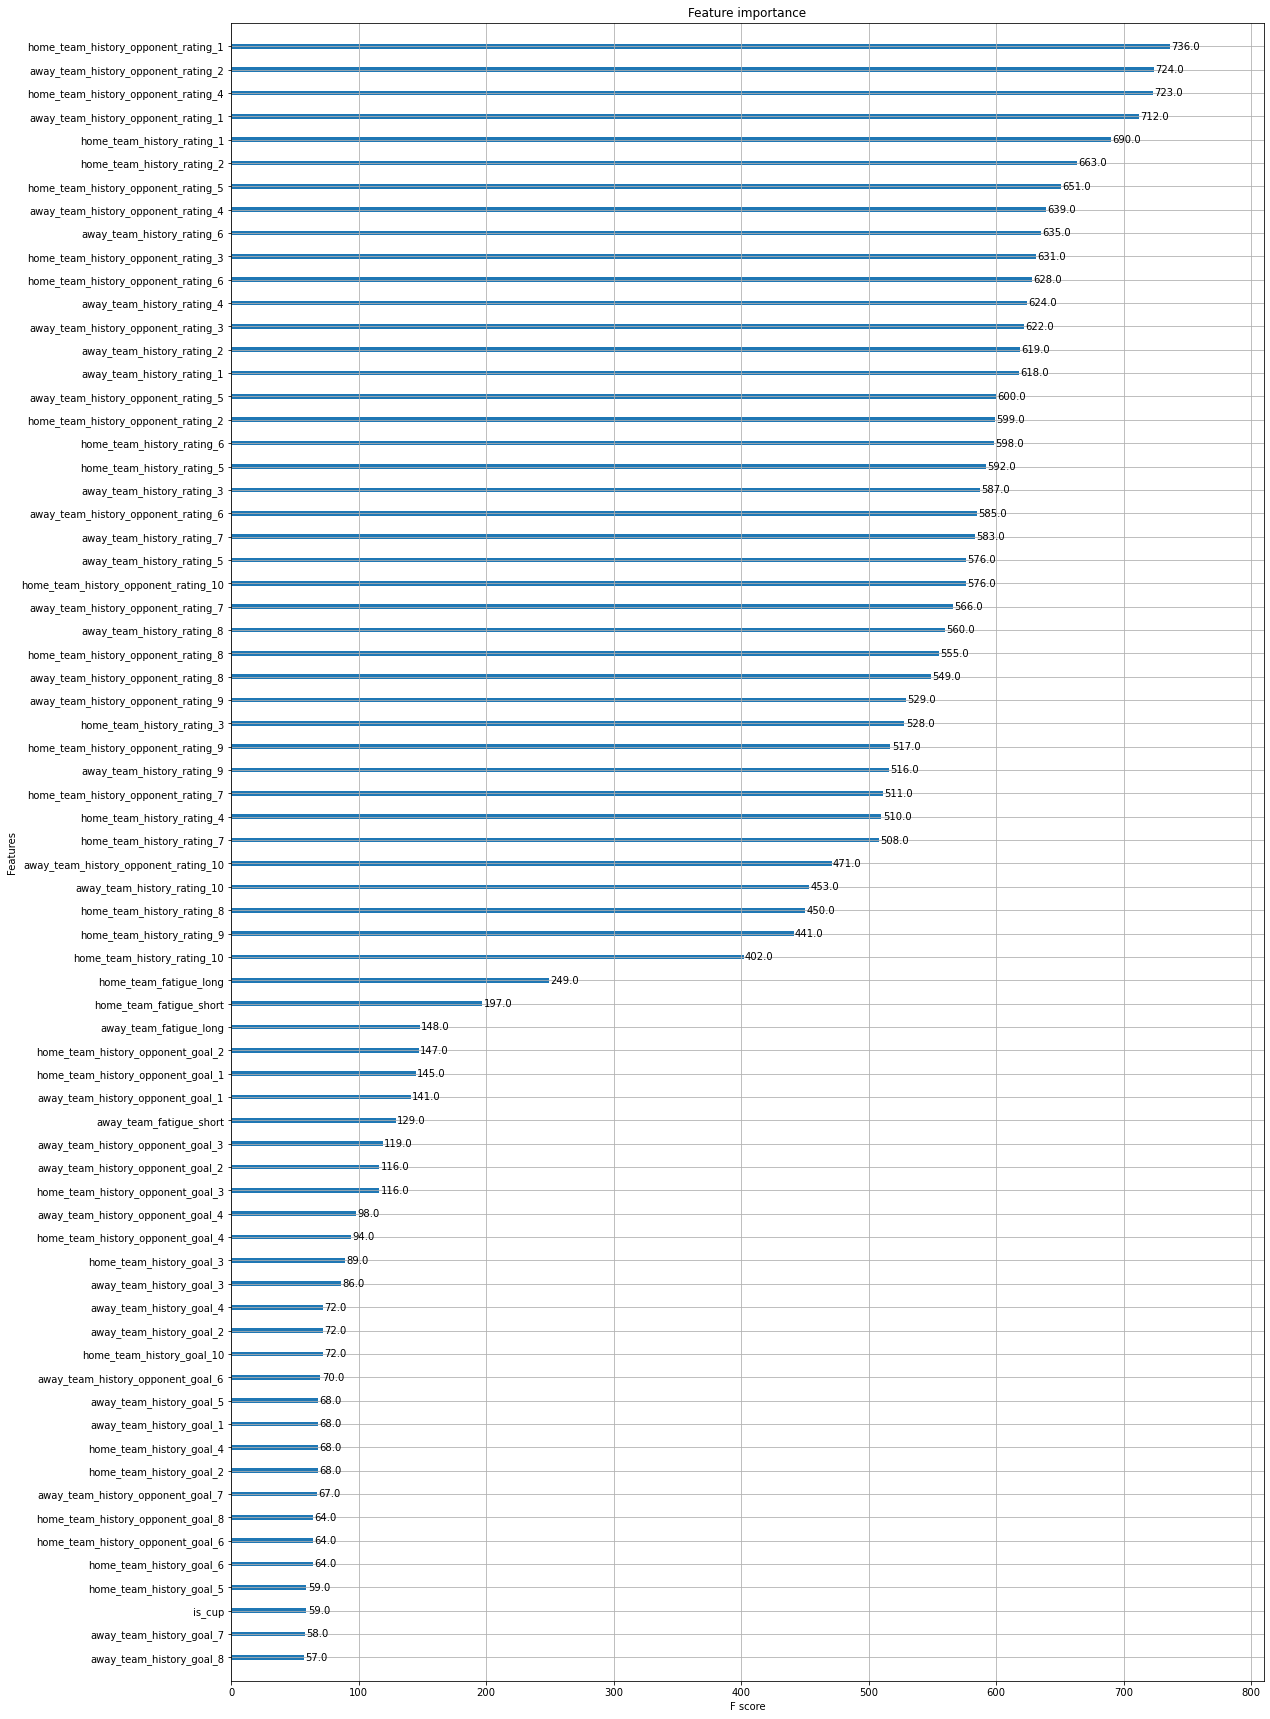

In [531]:
xgb.plot_importance(bst, max_num_features=70)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

In [159]:
dftest = pd.read_csv(r"C:\Users\joshu\sciebo\10. Semester\DLLab\football-match-probability-prediction\test.csv", low_memory=False)


,id,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_opponen

In [160]:
dftest.head()

,id,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_opponen

In [168]:
columns = list(dftest.columns)

f_home_team_name, f_away_team_name, f_match_date = [[feature] for feature in columns[1:4]]
f_league_name, f_league_id, f_is_cup, f_home_team_coach_id, f_away_team_coach_id = [[feature] for feature in columns[4:9]]

f_home_team_history_match_date = columns[9:19]
f_home_team_history_is_play_home = columns[19:29]
f_home_team_history_is_cup = columns[29:39]
f_home_team_history_goal = columns[39:49]
f_home_team_history_opponent_goal = columns[49:59]
f_home_team_history_rating = columns[59:69]
f_home_team_history_opponent_rating = columns[69:79]
f_home_team_history_coach = columns[79:89]
f_home_team_history_league_id = columns[89:99]
f_away_team_history_match_date = columns[99:109]
f_away_team_history_is_play_home = columns[109:119]
f_away_team_history_is_cup = columns[119:129]
f_away_team_history_goal = columns[129:139]
f_away_team_history_opponent_goal = columns[139:149]
f_away_team_history_rating = columns[149:159]
f_away_team_history_opponent_rating = columns[159:169]
f_away_team_history_coach = columns[169:179]
f_away_team_history_league_id = columns[179:189]

features_shitty = f_match_date + f_home_team_coach_id + f_away_team_coach_id + f_home_team_history_match_date + f_home_team_history_coach + f_away_team_history_match_date + f_away_team_history_coach
features_boolean = f_is_cup + f_home_team_history_is_play_home + f_home_team_history_is_cup + f_away_team_history_is_play_home + f_away_team_history_is_cup
features_numerical = f_home_team_history_goal + f_home_team_history_opponent_goal + f_home_team_history_rating + f_home_team_history_opponent_rating + f_away_team_history_goal + f_away_team_history_opponent_goal + f_away_team_history_rating + f_away_team_history_opponent_rating
features_categorical = f_home_team_name + f_away_team_name + f_league_name + f_league_id + f_home_team_history_league_id + f_away_team_history_league_id

# drop NaN and duplicates
dftest = dftest.dropna()
dftest = dftest.drop_duplicates()

# data processing 
data_settest = dftest[['id']]
data_settest = data_settest.join(dftest[features_boolean].astype(int))
data_settest = data_settest.join(dftest[features_numerical].astype(float))


In [170]:
data_settest.head()

,id,is_cup,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_opponent_goal_1,away_team_history_opponent_goal_2,away_team_history_opponent_goal_3,away_team_history_opponent_goal_4,away_team_history_opponent_goal_5,away_team_history_opponent_goal_6,away_team_history_opponent_goal_7,away_team_history_opponent_goal_8,away_team_history_opponent_goal_9,away_team_history_opponent_goal_10,away_team_history_rating_1,away_team_history_rating_2,away_team_history_rating_3,away_team_history_rating_4,away_team_history_rating_5,away_team_history_rating_6,away_team_history_rating_7,away_team_history_rating_8,away_team_history_rating_9,away_team_history_rating_10,away_team_history_opponent_rating_1,away_team_history_opponent_rating_2,away_team_history_opponent_rating_3,away_team_history_opponent_rating_4,away_team_history_opponent_rating_5,away_team_history_opponent_rating_6,away_team_history_opponent_rating_7,away_team_history_opponent_rating_8,away_team_history_opponent_rating_9,away_team_history_opponent_rating_10
0,17761448,0,0,0,1,1,0,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,4.134982,5.579979,4.604694,4.405645,3.802064,4.641138,4.703983,4.218740,4.382131,5.234275,7.460100,6.035358,7.761637,6.151000,10.470336,7.210415,6.590811,7.822580,7

In [171]:
X_test=data_settest.drop('id', axis=1)
X_test_d = xgb.DMatrix(X_test)

C:\Users\joshu\Anaconda3\envs\dllab\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [172]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [173]:
predictions

array([[0.33737358, 0.30400792, 0.3586185 ],
       [0.32893994, 0.30351362, 0.3675464 ],
       [0.2805744 , 0.2958725 , 0.42355305],
       ...,
       [0.35465288, 0.2772457 , 0.36810142],
       [0.23548067, 0.2473331 , 0.5171863 ],
       [0.31018546, 0.29400188, 0.39581266]], dtype=float32)